In [0]:
#@title
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# Definieer wat waardes voor je k's
k1 = 100000000 #E+L->EL
k2 = 10     #EL->E+L
k3 = 1000 #E+I-> EI
k4 = 0        #EI->E+I
k5 = 0         #EI -> EI*
k6 = 0         #EI* -> EI
kcat = 0.01   #EL -> EL*

# Definieer de concentraties op T=0 (in eerste instantie: voor inhibitie of substraat)
E0 = 0.1*10**-9
EL0 = 0
ELi0 = 0
EI0 = 0
EIi0 = 0  #(EI*)

#Definieer constanten
Is = [1*10**-6, 0.5*10**-6, 0.25*10**-6, 0*10**-9] #lijst van concentraties
L0 = 0.1*10**-6
dt = 0.01 #Dit is hoe groot je simulatie tijdstappen zijn

tframe = 1 #save a frame every 60 s
tincub = 600 #incubate for 1800 s
tsub = 3000 # Run with substrate for 1800 s

In [0]:
all_plots = []


for Ip in Is: # Loop over all I's
  concentraties = np.array([E0, EL0, ELi0, EI0, EIi0], dtype=np.double) #matrix van concentraties
  # Voor toevoeging van S

  I = Ip 
  L = 0 # Geen probe in je systeem tijdens pre-incubatie
                          # [         E,       EL, EL*,     EI, EI*]
  tijdevolutie0 = np.array([[-k1*L-k3*I,       k2,   0,     k4,   0],  #E
                            [      k1*L, -k2-kcat,   0,      0,   0],  #EL
                            [         0,     kcat,   0,      0,   0],  #EL*
                            [      k3*I,        0,   0, -k4-k5,  k6],  #EI
                            [         0,        0,   0,     k5, -k6]]) #EI*

  #verandering in E   = [E]*(-k3*I-k1*L) + [EL]*(k2)       + [EL*]*(0) + [EI]*(k4)     + [EI*]*(0)
  #verandering in EL  = [E]*(k1*L)       + [EL]*(-k2-kcat) + [EL*]*(0) + [EI]*(0)      + [EI*]*(0)
  #verandering in EL* = [E]*(0)          + [EL]*(kcat)     + [EL*]*(0) + [EI]*(0)      + [EI*]*(0)
  #verandering in EI  = [E]*(k3*I)       + [EL]*(0)        + [EL*]*(0) + [EI]*(-k4-k5) + [EI*]*(k6)
  #verandering in EI* = [E]*(0)          + [EL]*(0)        + [EL*]*(0) + [EI]*(k5)     + [EI*]*(-k6)


  #Na toevoeging van S
  L = L0
  I = Ip 
  tijdevolutie1 = np.array([[-k3*I-k1*L, k2, 0, k4, 0],
                           [k1*L, -k2-kcat, 0, 0, 0],
                           [0, kcat, 0, 0, 0],
                           [k3*I, 0, 0, -k4-k5, k6],
                           [0, 0, 0, k5, -k6]])
  # Maak een lijst van kopien van de concentraties
  plot = [concentraties.copy()]

  tijdconc = concentraties.copy()
  t = 0
  # Voor toevoging van S (tincub/dt stappen = 30min)
  for i in range(int(tincub/dt)):
      t+= 1
      tijdconc += np.dot(tijdevolutie0*dt, tijdconc) # Doe 1 dt tijdstap
      if (tijdconc < 0).any():
        raise ValueError("got a negative concentration, try decreasing dt")
      if t % int(tframe/dt)==0:
          plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

  # Na toevoeging van S (tsub/dt stappen)
  for i in range(int(tsub/dt)):
      t += 1
      tijdconc += np.dot(tijdevolutie1*dt, tijdconc) #Doe 1 dt tijdstap
      if (tijdconc < 0).any():
        raise ValueError("got a negative concentration, try decreasing dt")
    
      if t % int(tframe/dt)==0:
          plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

  all_plots.append(plot)

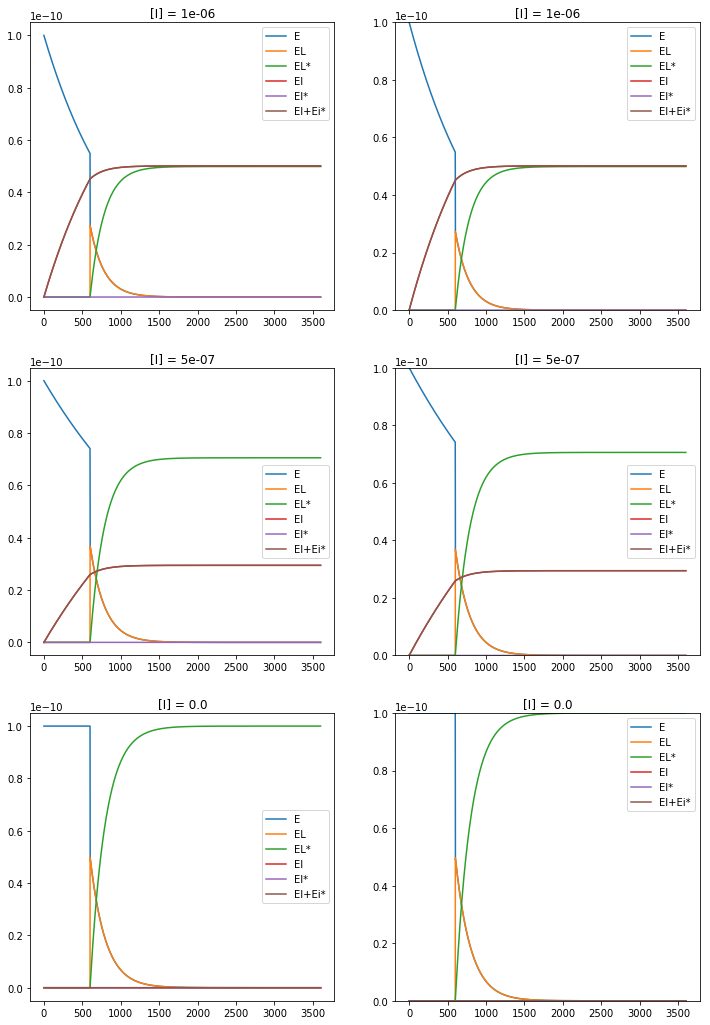

In [151]:
# This will make all the plots and dataframes
dataframes = []
fig, axes = plt.subplots(len(all_plots), 2, figsize=(12,len(all_plots)*6))
for n, plot in enumerate(all_plots):
  # Splits de lijst van figuren in E, EL, EL*, EI en EI*
  Eplot = [] 
  ESplot = []
  Pplot = []
  EIplot = []
  EIiplot = []
  EItot = []
  for frame in plot:
    Eplot.append(frame[0])
    ESplot.append(frame[1])
    Pplot.append(frame[2])
    EIplot.append(frame[3])
    EIiplot.append(frame[4])
    EItot.append(frame[3]+frame[4]) 
    
   # Plot de figuren
  labels = ('E', 'EL', "EL*", "EI", "EI*", "EI+Ei*")
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
    axes[n,0].plot(y, label=labels[i])
  axes[n,0].legend()
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
      axes[n,1].plot(y, label=labels[i])
  axes[n,1].legend()
  axes[n,1].set_ylim(0,E0) #zoom in tot E0
  axes[n,0].set_title("[I] = {}".format(str(Is[n])))
  axes[n,1].set_title("[I] = {}".format(str(Is[n])))
  
  df = pd.DataFrame(data={'E':Eplot,  "EI":EIplot, "EIi":EIiplot, "EL":ESplot, "ELi":Pplot})
  dataframes.append(df)
df = pd.concat(dataframes, keys=[I for I in Is], axis=1) # Combine all the dataframes

In [152]:
df

0.000001                     ... 0.000000                            
                 E            EI  EIi  ...      EIi            EL           ELi
0     1.000000e-10  0.000000e+00  0.0  ...      0.0  0.000000e+00  0.000000e+00
1     9.990005e-11  9.995052e-14  0.0  ...      0.0  0.000000e+00  0.000000e+00
2     9.980020e-11  1.998011e-13  0.0  ...      0.0  0.000000e+00  0.000000e+00
3     9.970045e-11  2.995519e-13  0.0  ...      0.0  0.000000e+00  0.000000e+00
4     9.960080e-11  3.992031e-13  0.0  ...      0.0  0.000000e+00  0.000000e+00
5     9.950125e-11  4.987546e-13  0.0  ...      0.0  0.000000e+00  0.000000e+00
6     9.940179e-11  5.982066e-13  0.0  ...      0.0  0.000000e+00  0.000000e+00
7     9.930244e-11  6.975592e-13  0.0  ...      0.0  0.000000e+00  0.000000e+00
8     9.920319e-11  7.968125e-13  0.0  ...      0.0  0.000000e+00  0.000000e+00
9     9.910403e-11  8.959666e-13  0.0  ...      0.0  0.000000e+00  0.000000e+00
10    9.900498e-11  9.950216e-13  0.0  ...      0.0  0.000000e+00  0.000000e+00
11    9.890602e-11  1.093978e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
12    9.880717e-11  1.192835e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
13    9.870841e-11  1.291593e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
14    9.860975e-11  1.390252e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
15    9.851119e-11  1.488813e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
16    9.841272e-11  1.587276e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
17    9.831436e-11  1.685640e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
18    9.821609e-11  1.783906e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
19    9.811793e-11  1.882073e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
20    9.801986e-11  1.980142e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
21    9.792189e-11  2.078114e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
22    9.782401e-11  2.175987e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
23    9.772624e-11  2.273763e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
24    9.762856e-11  2.371441e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
25    9.753098e-11  2.469021e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
26    9.743350e-11  2.566504e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
27    9.733611e-11  2.663889e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
28    9.723882e-11  2.761177e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
29    9.714163e-11  2.858368e-12  0.0  ...      0.0  0.000000e+00  0.000000e+00
...            ...           ...  ...  ...      ...           ...           ...
3571  2.203483e-18  5.011272e-11  0.0  ...      0.0  1.774096e-17  9.999996e-11
3572  2.191399e-18  5.011272e-11  0.0  ...      0.0  1.765249e-17  9.999996e-11
3573  2.179381e-18  5.011272e-11  0.0  ...      0.0  1.756447e-17  9.999996e-11
3574  2.167430e-18  5.011272e-11  0.0  ...      0.0  1.747689e-17  9.999997e-11
3575  2.155543e-18  5.011272e-11  0.0  ...      0.0  1.738974e-17  9.999997e-11
3576  2.143722e-18  5.011272e-11  0.0  ...      0.0  1.730303e-17  9.999997e-11
3577  2.131966e-18  5.011272e-11  0.0  ...      0.0  1.721675e-17  9.999997e-11
3578  2.120274e-18  5.011272e-11  0.0  ...      0.0  1.713090e-17  9.999997e-11
3579  2.108647e-18  5.011272e-11  0.0  ...      0.0  1.704548e-17  9.999997e-11
3580  2.097083e-18  5.011272e-11  0.0  ...      0.0  1.696048e-17  9.999997e-11
3581  2.085582e-18  5.011272e-11  0.0  ...      0.0  1.687591e-17  9.999997e-11
3582  2.074145e-18  5.011272e-11  0.0  ...      0.0  1.679176e-17  9.999997e-11
3583  2.062770e-18  5.011272e-11  0.0  ...      0.0  1.670803e-17  9.999997e-11
3584  2.051458e-18  5.011272e-11  0.0  ...      0.0  1.662472e-17  9.999997e-11
3585  2.040207e-18  5.011272e-11  0.0  ...      0.0  1.654182e-17  9.999997e-11
3586  2.029019e-18  5.011272e-11  0.0  ...      0.0  1.645934e-17  9.999997e-11
3587  2.017892e-18  5.011272e-11  0.0  ...      0.0  1.637726e-17  9.999997e-11
3588  2.00

In [153]:
df.iloc[30]

1.000000e-06  E      9.704454e-11
              EI     2.955461e-12
              EIi    0.000000e+00
              EL     0.000000e+00
              ELi    0.000000e+00
5.000000e-07  E      9.851119e-11
              EI     1.488810e-12
              EIi    0.000000e+00
              EL     0.000000e+00
              ELi    0.000000e+00
0.000000e+00  E      1.000000e-10
              EI     0.000000e+00
              EIi    0.000000e+00
              EL     0.000000e+00
              ELi    0.000000e+00
Name: 30, dtype: float64

In [154]:
print(df.to_csv())

,1e-06,1e-06,1e-06,1e-06,1e-06,5e-07,5e-07,5e-07,5e-07,5e-07,0.0,0.0,0.0,0.0,0.0
,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi
0,1.0000000000000002e-10,0.0,0.0,0.0,0.0,1.0000000000000002e-10,0.0,0.0,0.0,0.0,1.0000000000000002e-10,0.0,0.0,0.0,0.0
1,9.990004948383396e-11,9.995051616607956e-14,0.0,0.0,0.0,9.995001237297896e-11,4.998762702100495e-14,0.0,0.0,0.0,1.0000000000000002e-10,0.0,0.0,0.0,0.0
2,9.980019886872473e-11,1.9980113127534042e-13,0.0,0.0,0.0,9.990004973358654e-11,9.995026641345799e-14,0.0,0.0,0.0,1.0000000000000002e-10,0.0,0.0,0.0,0.0
3,9.970044805482067e-11,2.995519451794046e-13,0.0,0.0,0.0,9.985011206933188e-11,1.498879306680817e-13,0.0,0.0,0.0,1.0000000000000002e-10,0.0,0.0,0.0,0.0
4,9.960079694237e-11,3.9920305763009184e-13,0.0,0.0,0.0,9.980019936773055e-11,1.9980063226935478e-13,0.0,0.0,0.0,1.0000000000000002e-10,0.0,0.0,0.0,0.0
5,9.950124543172059e-11,4.987545682795194e-13,0.0,0.0,0.0,9.975031161630442e-11,2.4968838369551525e-13,0.0,0.0,0.0,1.0000000000000002e-10,0